In [1]:
# Import necessary libraries for loading the dataset
import torch
from torchvision import datasets, transforms
from custom_labels import label_mapping, apply_custom_labels

# Load the fashion MNIST dataset with custom labels

In [2]:
%%time

data_path = '../data'

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root=data_path, train=True, transform=transform, download=True)
train_dataset.targets = apply_custom_labels(train_dataset.targets)

test_dataset = datasets.FashionMNIST(root=data_path, train=False, transform=transform, download=True)
test_dataset.targets = apply_custom_labels(test_dataset.targets)

CPU times: user 2.25 s, sys: 343 ms, total: 2.59 s
Wall time: 1.48 s


# Deep Learning Experimentation and Evaluation

In [3]:
# import libraries needed for the DL experiments and evaluation
import torch.nn as nn
from torch.utils.data import random_split
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import os

In [4]:
%%time

batch_size = 64

# taking 20% of train as validation
valid_size = int(0.2 * len(train_dataset)) 
train_size = len(train_dataset) - valid_size

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

CPU times: user 8.56 ms, sys: 6.89 ms, total: 15.5 ms
Wall time: 3.16 ms


In [5]:
def train(model, train_loader, valid_loader, criterion, optimizer, num_epochs, save_dir=None):
    """
    Train the model and save the best checkpoint.
    Parameters:
        model: Model to train
        train_loader: Training data loader
        valid_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        num_epochs: Number of epochs
        save_dir: Directory to save the best checkpoint and loss curves
    """
    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')

    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculating average training loss for this epoch
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        valid_loss = 0.0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

        # Calculating average validation loss for this epoch
        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}')

        # save model checkpoint
        if save_dir and valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            checkpoint_path = os.path.join(save_dir, f'best_checkpoint.pth')
            print(f"Saving best checkpoint to {checkpoint_path}")
            torch.save(model.state_dict(), checkpoint_path)


    # Plot training and validation curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)

    if save_dir:
        curve_path = os.path.join(save_dir, 'loss_curves.png')
        plt.savefig(curve_path)
    else:
        plt.show()


In [6]:
def evaluate(model, test_loader, num_classes):
    """
    Evaluate the model on the test set
    Parameter:
        model: Model to be evaluated
        test_loader: Test set loader
        num_classes: Number of classes
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    confusion = confusion_matrix(y_true, y_pred)

    class_report = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(num_classes)])

    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print('\nConfusion Matrix:')
    print(confusion)
    print('\nClassification Report:')
    print(class_report)


## Single CNN model

In [7]:
class SingleCNN(nn.Module):
    def __init__(self):
        super(SingleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.fc1 = nn.Linear(in_features=32 * 12 * 12, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=len(label_mapping))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 32 * 12 * 12)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 1/10, Train Loss: 0.1457, Valid Loss: 0.1134
Saving best checkpoint to ./outputs/single_cnn/best_checkpoint.pth
Epoch 2/10, Train Loss: 0.0862, Valid Loss: 0.0866
Saving best checkpoint to ./outputs/single_cnn/best_checkpoint.pth
Epoch 3/10, Train Loss: 0.0678, Valid Loss: 0.0715
Saving best checkpoint to ./outputs/single_cnn/best_checkpoint.pth
Epoch 4/10, Train Loss: 0.0554, Valid Loss: 0.0640
Saving best checkpoint to ./outputs/single_cnn/best_checkpoint.pth
Epoch 5/10, Train Loss: 0.0459, Valid Loss: 0.0607
Saving best checkpoint to ./outputs/single_cnn/best_checkpoint.pth
Epoch 6/10, Train Loss: 0.0404, Valid Loss: 0.0581
Saving best checkpoint to ./outputs/single_cnn/best_checkpoint.pth
Epoch 7/10, Train Loss: 0.0338, Valid Loss: 0.0594
Epoch 8/10, Train Loss: 0.0281, Valid Loss: 0.0690
Epoch 9/10, Train Loss: 0.0253, Valid Loss: 0.0614
Epoch 10/10, Train Loss: 0.0210, Valid Loss: 0.0685
CPU times: user 8min 32s, sys: 7min 23s, total: 15min 56s
Wall time: 2min 10s


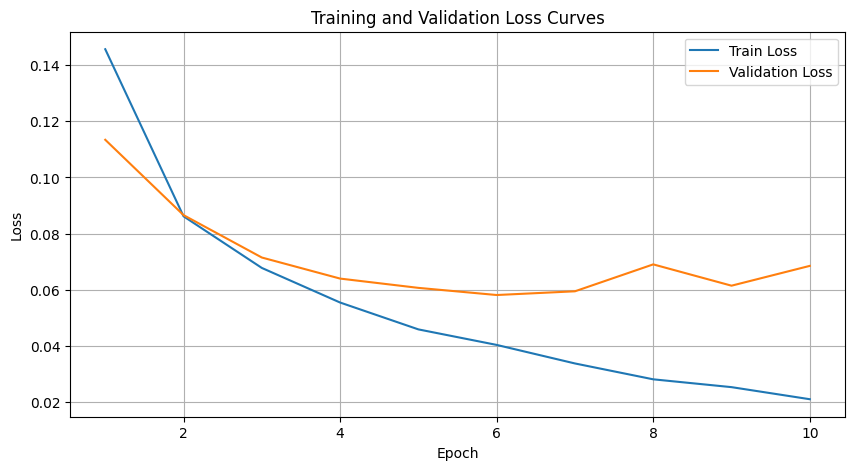

In [8]:
%%time

# Initialize the model
single_cnn = SingleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(single_cnn.parameters(), lr=0.001)

train(single_cnn, train_loader, valid_loader, criterion, optimizer, num_epochs=10,save_dir='./outputs/single_cnn')


In [9]:
%%time

# Evaluate the single cnn model
evaluate(single_cnn, test_loader, num_classes=5)

Accuracy: 97.89%
F1 Score: 0.9788
Precision: 0.9788
Recall: 0.9789

Confusion Matrix:
[[3926    2   61    3    8]
 [   7  987    5    0    1]
 [  92    6  900    0    2]
 [   1    0    0 2999    0]
 [  16    1    0    6  977]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.98      4000
     Class 1       0.99      0.99      0.99      1000
     Class 2       0.93      0.90      0.92      1000
     Class 3       1.00      1.00      1.00      3000
     Class 4       0.99      0.98      0.98      1000

    accuracy                           0.98     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.98      0.98      0.98     10000

CPU times: user 5.08 s, sys: 5.19 s, total: 10.3 s
Wall time: 1.45 s


### Data Augumentation 

Data Augumentation can be used to treat class imbalance problem, however in this particular case before moving towards class imbalance problem, lets proceed to help the model at hand to generalize, above loss curves showcase that model is overfitting in very early stage of the training (epoch 2). Lets augument the data to try to combat this issue.

In [10]:
%%time

data_path = '../data'

# performig some transformations to the data for data augumentation
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
])

train_dataset_aug = datasets.FashionMNIST(root=data_path, train=True, transform=transform, download=True)
train_dataset_aug.targets = apply_custom_labels(train_dataset_aug.targets)

valid_size_aug = int(0.2 * len(train_dataset_aug)) 
train_size_aug = len(train_dataset_aug) - valid_size_aug

train_dataset_aug, valid_dataset_aug = random_split(train_dataset_aug, [train_size_aug, valid_size_aug])

batch_size = 64
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
valid_loader_aug = DataLoader(valid_dataset_aug, batch_size=batch_size, shuffle=True)

CPU times: user 1.39 s, sys: 868 ms, total: 2.25 s
Wall time: 1.24 s


Epoch 1/10, Train Loss: 0.1764, Valid Loss: 0.1229
Saving best checkpoint to ./outputs/single_cnn_aug/best_checkpoint.pth
Epoch 2/10, Train Loss: 0.1046, Valid Loss: 0.0888
Saving best checkpoint to ./outputs/single_cnn_aug/best_checkpoint.pth
Epoch 3/10, Train Loss: 0.0891, Valid Loss: 0.0795
Saving best checkpoint to ./outputs/single_cnn_aug/best_checkpoint.pth
Epoch 4/10, Train Loss: 0.0792, Valid Loss: 0.0746
Saving best checkpoint to ./outputs/single_cnn_aug/best_checkpoint.pth
Epoch 5/10, Train Loss: 0.0722, Valid Loss: 0.0826
Epoch 6/10, Train Loss: 0.0676, Valid Loss: 0.0787
Epoch 7/10, Train Loss: 0.0636, Valid Loss: 0.0796
Epoch 8/10, Train Loss: 0.0598, Valid Loss: 0.0666
Saving best checkpoint to ./outputs/single_cnn_aug/best_checkpoint.pth
Epoch 9/10, Train Loss: 0.0559, Valid Loss: 0.0709
Epoch 10/10, Train Loss: 0.0541, Valid Loss: 0.0635
Saving best checkpoint to ./outputs/single_cnn_aug/best_checkpoint.pth
CPU times: user 13min 25s, sys: 17min 56s, total: 31min 21s
Wal

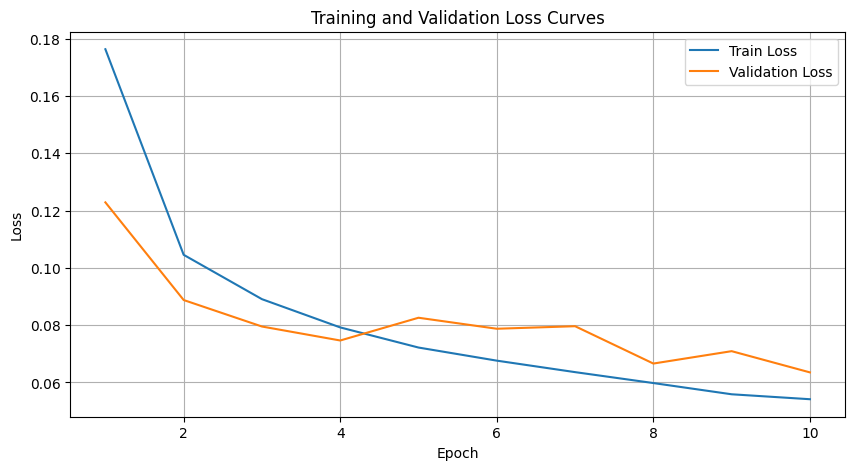

In [11]:
%%time

# Initialize the model
single_cnn = SingleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(single_cnn.parameters(), lr=0.001)

# Applying sugumented data for training single_cnn model
train(single_cnn, train_loader_aug, valid_loader_aug, criterion, optimizer, num_epochs=10,save_dir='./outputs/single_cnn_aug')


In [12]:
%%time

evaluate(single_cnn, test_loader, num_classes=5)

Accuracy: 97.70%
F1 Score: 0.9769
Precision: 0.9769
Recall: 0.9770

Confusion Matrix:
[[3924    1   60    2   13]
 [  13  971   15    0    1]
 [ 101    1  895    0    3]
 [   1    0    0 2998    1]
 [  12    0    1    5  982]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.97      4000
     Class 1       1.00      0.97      0.98      1000
     Class 2       0.92      0.90      0.91      1000
     Class 3       1.00      1.00      1.00      3000
     Class 4       0.98      0.98      0.98      1000

    accuracy                           0.98     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.98      0.98      0.98     10000

CPU times: user 4.88 s, sys: 4.61 s, total: 9.49 s
Wall time: 1.5 s


### Inlcuding dropout

In [13]:
class SingleCNNWithDropout(nn.Module):
    def __init__(self):
        super(SingleCNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.fc1 = nn.Linear(in_features=32 * 12 * 12, out_features=100)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=100, out_features=len(label_mapping))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 32 * 12 * 12)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:
%%time

# Initialize the model
single_cnn_with_dropout = SingleCNNWithDropout()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(single_cnn.parameters(), lr=0.001)

CPU times: user 3.71 ms, sys: 7.81 ms, total: 11.5 ms
Wall time: 2.63 ms


Epoch 1/10, Train Loss: 1.6374, Valid Loss: 1.6348
Saving best checkpoint to ./outputs/single_cnn_drop_aug/best_checkpoint.pth
Epoch 2/10, Train Loss: 1.6363, Valid Loss: 1.6350
Epoch 3/10, Train Loss: 1.6368, Valid Loss: 1.6343
Saving best checkpoint to ./outputs/single_cnn_drop_aug/best_checkpoint.pth
Epoch 4/10, Train Loss: 1.6370, Valid Loss: 1.6351
Epoch 5/10, Train Loss: 1.6360, Valid Loss: 1.6353
Epoch 6/10, Train Loss: 1.6368, Valid Loss: 1.6346
Epoch 7/10, Train Loss: 1.6362, Valid Loss: 1.6350
Epoch 8/10, Train Loss: 1.6372, Valid Loss: 1.6348
Epoch 9/10, Train Loss: 1.6366, Valid Loss: 1.6350
Epoch 10/10, Train Loss: 1.6372, Valid Loss: 1.6349
CPU times: user 12min 46s, sys: 16min 26s, total: 29min 12s
Wall time: 4min 21s


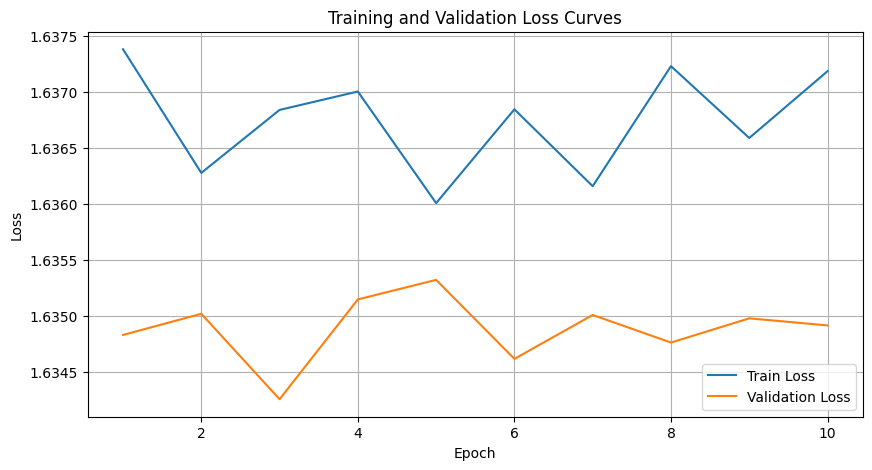

In [15]:
%%time

# Training single_cnn_with_dropout on augumented data
train(single_cnn_with_dropout, train_loader_aug, valid_loader_aug, criterion, optimizer, num_epochs=10,save_dir='./outputs/single_cnn_drop_aug')

No convergence reached. We can increase number of epochs to see if the model learns, however, considering that we are training on augumented data and using a simple network the above curve makes sense. On augumentation, we have increased the dataset size and also included variations of the image (new patterns), on top of this when we added dropout the single cnn network is struggling to learn especially classes 1,2 and 3. This can also be understood as some of these classes have less samples as we observed in class distribution analysis. Another explanation can be that these classes (bags, shoes have more complex partterns than upper part and bottom part)

### Treating class imbalance

In [16]:
%%time

# calculating class weights
num_classes = len(label_mapping)
class_sizes = np.zeros(num_classes, dtype=int)

for _, labels in train_loader:
    class_sizes += np.bincount(labels.numpy(), minlength=num_classes)

class_weights = [sum(class_sizes) / (num_classes * size) for size in class_sizes]
# Normalizing
class_weights_normalized = [round(weight / sum(class_weights),2) for weight in class_weights]

class_weights_normalized


CPU times: user 2.63 s, sys: 454 ms, total: 3.08 s
Wall time: 2.6 s


[0.07, 0.28, 0.28, 0.09, 0.28]

Epoch 1/20, Train Loss: 0.2098, Valid Loss: 0.1305
Saving best checkpoint to ./outputs/single_cnn_cw/best_checkpoint.pth
Epoch 2/20, Train Loss: 0.1265, Valid Loss: 0.1200
Saving best checkpoint to ./outputs/single_cnn_cw/best_checkpoint.pth
Epoch 3/20, Train Loss: 0.1071, Valid Loss: 0.0921
Saving best checkpoint to ./outputs/single_cnn_cw/best_checkpoint.pth
Epoch 4/20, Train Loss: 0.0966, Valid Loss: 0.1090
Epoch 5/20, Train Loss: 0.0858, Valid Loss: 0.0837
Saving best checkpoint to ./outputs/single_cnn_cw/best_checkpoint.pth
Epoch 6/20, Train Loss: 0.0796, Valid Loss: 0.0889
Epoch 7/20, Train Loss: 0.0757, Valid Loss: 0.0769
Saving best checkpoint to ./outputs/single_cnn_cw/best_checkpoint.pth
Epoch 8/20, Train Loss: 0.0705, Valid Loss: 0.0764
Saving best checkpoint to ./outputs/single_cnn_cw/best_checkpoint.pth
Epoch 9/20, Train Loss: 0.0673, Valid Loss: 0.0795
Epoch 10/20, Train Loss: 0.0599, Valid Loss: 0.0781
Epoch 11/20, Train Loss: 0.0592, Valid Loss: 0.0774
Epoch 12/20, Trai

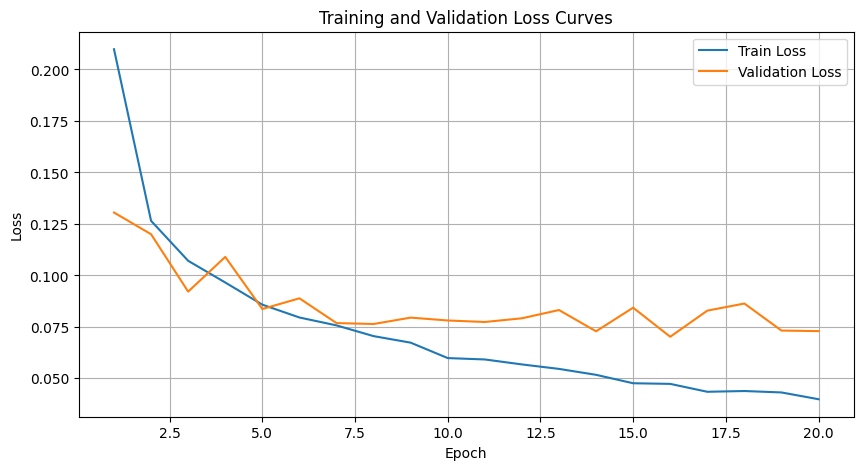

In [17]:
%%time

# Initialize the model
single_cnn_cw = SingleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights_normalized))
optimizer = optim.Adam(single_cnn_cw.parameters(), lr=0.001)

# Performing training on single cnn class weights model using augumented data
train(single_cnn_cw, train_loader_aug, valid_loader_aug, criterion, optimizer, num_epochs=20,save_dir='./outputs/single_cnn_cw')


In [18]:
%%time

evaluate(single_cnn_cw, test_loader, num_classes=5)

Accuracy: 97.58%
F1 Score: 0.9762
Precision: 0.9772
Recall: 0.9758

Confusion Matrix:
[[3831    3  149    0   17]
 [   2  992    5    0    1]
 [  43    4  952    0    1]
 [   1    0    0 2998    1]
 [   8    0    2    5  985]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.96      0.97      4000
     Class 1       0.99      0.99      0.99      1000
     Class 2       0.86      0.95      0.90      1000
     Class 3       1.00      1.00      1.00      3000
     Class 4       0.98      0.98      0.98      1000

    accuracy                           0.98     10000
   macro avg       0.96      0.98      0.97     10000
weighted avg       0.98      0.98      0.98     10000

CPU times: user 5.12 s, sys: 5.28 s, total: 10.4 s
Wall time: 1.48 s


### Normalization

In [19]:
%%time

data_path = '../data'

# Normalizing the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset_norm = datasets.FashionMNIST(root=data_path, train=True, transform=transform, download=True)
train_dataset_norm.targets = apply_custom_labels(train_dataset_norm.targets)

test_dataset_norm = datasets.FashionMNIST(root=data_path, train=False, transform=transform, download=True)
test_dataset_norm.targets = apply_custom_labels(test_dataset_norm.targets)

valid_size_norm = int(0.2 * len(train_dataset_norm)) 
train_size_norm = len(train_dataset_norm) - valid_size_norm

train_dataset_norm, valid_dataset_norm = random_split(train_dataset_norm, [train_size_norm, valid_size_norm])

batch_size = 64
train_loader_norm = DataLoader(train_dataset_norm, batch_size=batch_size, shuffle=True)
valid_loader_norm = DataLoader(valid_dataset_norm, batch_size=batch_size, shuffle=True)
test_loader_norm = DataLoader(test_dataset_norm, batch_size=batch_size, shuffle=True)


CPU times: user 1.59 s, sys: 710 ms, total: 2.3 s
Wall time: 1.57 s


Epoch 1/10, Train Loss: 0.1568, Valid Loss: 0.1144
Saving best checkpoint to ./outputs/single_cnn_norm/best_checkpoint.pth
Epoch 2/10, Train Loss: 0.0927, Valid Loss: 0.0953
Saving best checkpoint to ./outputs/single_cnn_norm/best_checkpoint.pth
Epoch 3/10, Train Loss: 0.0699, Valid Loss: 0.0898
Saving best checkpoint to ./outputs/single_cnn_norm/best_checkpoint.pth
Epoch 4/10, Train Loss: 0.0551, Valid Loss: 0.1003
Epoch 5/10, Train Loss: 0.0459, Valid Loss: 0.0877
Saving best checkpoint to ./outputs/single_cnn_norm/best_checkpoint.pth
Epoch 6/10, Train Loss: 0.0389, Valid Loss: 0.0991
Epoch 7/10, Train Loss: 0.0319, Valid Loss: 0.0960
Epoch 8/10, Train Loss: 0.0268, Valid Loss: 0.0966
Epoch 9/10, Train Loss: 0.0254, Valid Loss: 0.1082
Epoch 10/10, Train Loss: 0.0213, Valid Loss: 0.1050
CPU times: user 9min 29s, sys: 8min 54s, total: 18min 24s
Wall time: 2min 38s


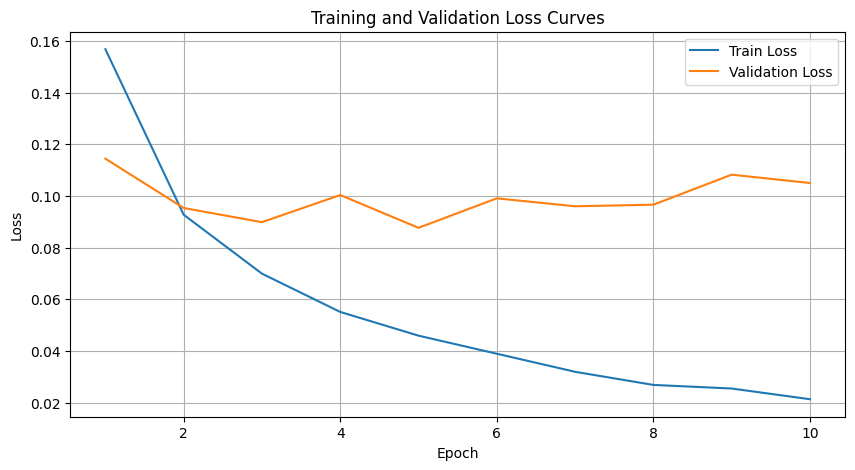

In [20]:
%%time

# Initialize the model
single_cnn_norm = SingleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights_normalized))
optimizer = optim.Adam(single_cnn_norm.parameters(), lr=0.001)

# Performing training on single cnn using normalized data
train(single_cnn_norm, train_loader_norm, valid_loader_norm, criterion, optimizer, num_epochs=10,save_dir='./outputs/single_cnn_norm')


In [21]:
evaluate(single_cnn_norm, test_loader_norm, num_classes=5)

Accuracy: 97.65%
F1 Score: 0.9768
Precision: 0.9773
Recall: 0.9765

Confusion Matrix:
[[3874    1  108    3   14]
 [   7  974   19    0    0]
 [  57    0  942    0    1]
 [   3    0    1 2995    1]
 [   5    0    6    9  980]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.97      0.98      4000
     Class 1       1.00      0.97      0.99      1000
     Class 2       0.88      0.94      0.91      1000
     Class 3       1.00      1.00      1.00      3000
     Class 4       0.98      0.98      0.98      1000

    accuracy                           0.98     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.98      0.98      0.98     10000



## Double CNN model

In [22]:
class DoubleCNN(nn.Module):
    def __init__(self):
        super(DoubleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(in_features=64 * 5 * 5, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=len(label_mapping))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Epoch 1/10, Train Loss: 0.2162, Valid Loss: 0.1245
Saving best checkpoint to ./outputs/double_cnn/best_checkpoint.pth
Epoch 2/10, Train Loss: 0.1158, Valid Loss: 0.0967
Saving best checkpoint to ./outputs/double_cnn/best_checkpoint.pth
Epoch 3/10, Train Loss: 0.0990, Valid Loss: 0.0896
Saving best checkpoint to ./outputs/double_cnn/best_checkpoint.pth
Epoch 4/10, Train Loss: 0.0891, Valid Loss: 0.0811
Saving best checkpoint to ./outputs/double_cnn/best_checkpoint.pth
Epoch 5/10, Train Loss: 0.0830, Valid Loss: 0.0789
Saving best checkpoint to ./outputs/double_cnn/best_checkpoint.pth
Epoch 6/10, Train Loss: 0.0775, Valid Loss: 0.0850
Epoch 7/10, Train Loss: 0.0709, Valid Loss: 0.0730
Saving best checkpoint to ./outputs/double_cnn/best_checkpoint.pth
Epoch 8/10, Train Loss: 0.0666, Valid Loss: 0.0683
Saving best checkpoint to ./outputs/double_cnn/best_checkpoint.pth
Epoch 9/10, Train Loss: 0.0643, Valid Loss: 0.0763
Epoch 10/10, Train Loss: 0.0597, Valid Loss: 0.0669
Saving best checkpoi

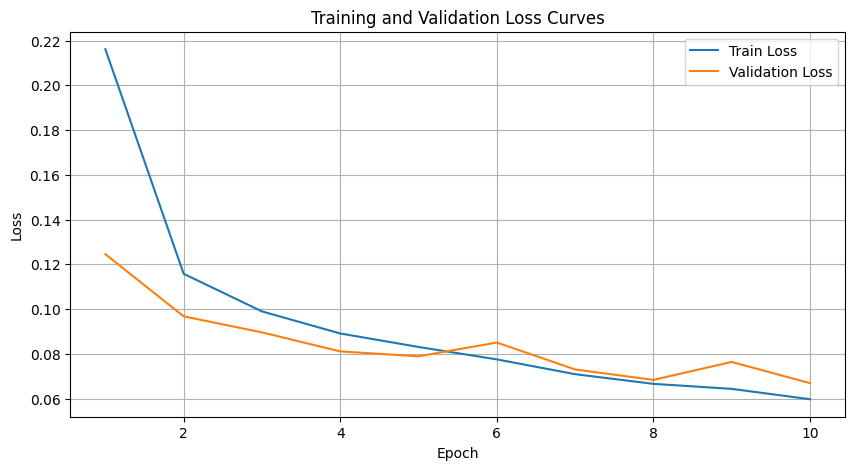

In [23]:
%%time

# Initialize the model
double_cnn = DoubleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(double_cnn.parameters(), lr=0.001)

# Training double cnn using augumented data
train(double_cnn, train_loader_aug, valid_loader_aug, criterion, optimizer, num_epochs=10,save_dir='./outputs/double_cnn')


In [24]:
%%time

# Evaluate the baseline model
evaluate(double_cnn, test_loader, num_classes=5)


Accuracy: 97.66%
F1 Score: 0.9766
Precision: 0.9767
Recall: 0.9766

Confusion Matrix:
[[3922    2   72    0    4]
 [  10  979   11    0    0]
 [  88    6  905    0    1]
 [   1    0    1 2998    0]
 [  31    0    1    6  962]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.97      4000
     Class 1       0.99      0.98      0.99      1000
     Class 2       0.91      0.91      0.91      1000
     Class 3       1.00      1.00      1.00      3000
     Class 4       0.99      0.96      0.98      1000

    accuracy                           0.98     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.98      0.98      0.98     10000

CPU times: user 6.73 s, sys: 5.05 s, total: 11.8 s
Wall time: 2.12 s


Epoch 1/10, Train Loss: 0.2322, Valid Loss: 0.1429
Saving best checkpoint to ./outputs/double_cnn_cw/best_checkpoint.pth
Epoch 2/10, Train Loss: 0.1323, Valid Loss: 0.1260
Saving best checkpoint to ./outputs/double_cnn_cw/best_checkpoint.pth
Epoch 3/10, Train Loss: 0.1158, Valid Loss: 0.1026
Saving best checkpoint to ./outputs/double_cnn_cw/best_checkpoint.pth
Epoch 4/10, Train Loss: 0.1028, Valid Loss: 0.1070
Epoch 5/10, Train Loss: 0.0942, Valid Loss: 0.0915
Saving best checkpoint to ./outputs/double_cnn_cw/best_checkpoint.pth
Epoch 6/10, Train Loss: 0.0870, Valid Loss: 0.0813
Saving best checkpoint to ./outputs/double_cnn_cw/best_checkpoint.pth
Epoch 7/10, Train Loss: 0.0803, Valid Loss: 0.0775
Saving best checkpoint to ./outputs/double_cnn_cw/best_checkpoint.pth
Epoch 8/10, Train Loss: 0.0739, Valid Loss: 0.0813
Epoch 9/10, Train Loss: 0.0703, Valid Loss: 0.0755
Saving best checkpoint to ./outputs/double_cnn_cw/best_checkpoint.pth
Epoch 10/10, Train Loss: 0.0647, Valid Loss: 0.0696

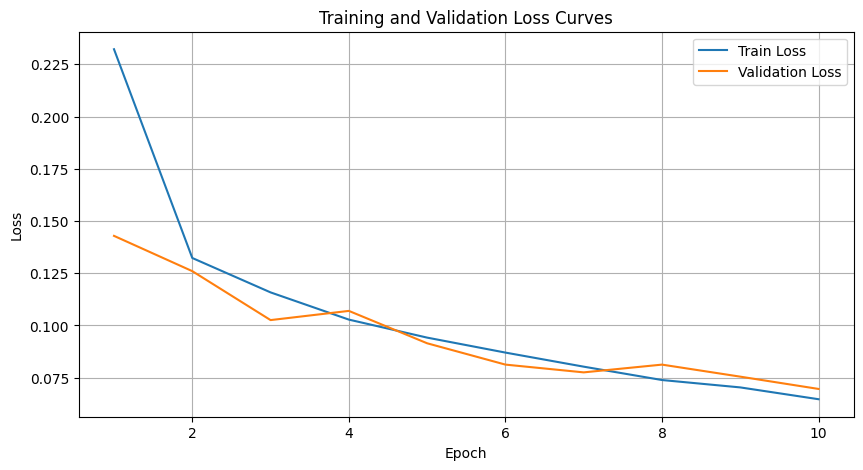

In [25]:
%%time

# Initialize the model
double_cnn_cw = DoubleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights_normalized))
optimizer = optim.Adam(double_cnn_cw.parameters(), lr=0.001)

# Training double cnn using augumented data and using class weights
train(double_cnn_cw, train_loader_aug, valid_loader_aug, criterion, optimizer, num_epochs=10,save_dir='./outputs/double_cnn_cw')


In [26]:
%%time

# Evaluate the baseline model
evaluate(double_cnn_cw, test_loader, num_classes=5)


Accuracy: 97.11%
F1 Score: 0.9717
Precision: 0.9737
Recall: 0.9711

Confusion Matrix:
[[3790    4  180    1   25]
 [   5  981   12    0    2]
 [  29    5  966    0    0]
 [   1    0    2 2996    1]
 [  13    0    3    6  978]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.95      0.97      4000
     Class 1       0.99      0.98      0.99      1000
     Class 2       0.83      0.97      0.89      1000
     Class 3       1.00      1.00      1.00      3000
     Class 4       0.97      0.98      0.98      1000

    accuracy                           0.97     10000
   macro avg       0.96      0.97      0.96     10000
weighted avg       0.97      0.97      0.97     10000

CPU times: user 7.73 s, sys: 6.5 s, total: 14.2 s
Wall time: 1.97 s


### Other Experiments
This notebook only contains technique experiments like augumentation, normalization, dropout, class weights, using more complex model etc. However we havent experimented with hyper parameters like learning_rate, kernal size, padding etc.. apart from that we have fixed optimizer, activation function and loss function. We can derive further analysis and conclusions from the experiments performed so far to choose next phase of experiments.